In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load dataset

In [ ]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/data/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/data/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/data/test',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)

Found 7020 images belonging to 20 classes.
Found 3008 images belonging to 20 classes.
Found 2007 images belonging to 20 classes.


# EfficientNetB0

In [ ]:
input_layer = K.Input(shape=(160,160,3))
effnet_model = K.applications.EfficientNetB0(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in effnet_model.layers:
    layer.trainable = True
for i, layer in enumerate(effnet_model.layers):
    print(i, layer.name, "-", layer.trainable)

16705208/16705208 [==============================] - 2s 0us/step
0 input_1 - True
1 rescaling - True
2 normalization - True
3 tf.math.truediv - True
4 stem_conv_pad - True
5 stem_conv - True
6 stem_bn - True
7 stem_activation - True
8 block1a_dwconv - True
9 block1a_bn - True
10 block1a_activation - True
11 block1a_se_squeeze - True
12 block1a_se_reshape - True
13 block1a_se_reduce - True
14 block1a_se_expand - True
15 block1a_se_excite - True
16 block1a_project_conv - True
17 block1a_project_bn - True
18 block2a_expand_conv - True
19 block2a_expand_bn - True
20 block2a_expand_activation - True
21 block2a_dwconv_pad - True
22 block2a_dwconv - True
23 block2a_bn - True
24 block2a_activation - True
25 block2a_se_squeeze - True
26 block2a_se_reshape - True
27 block2a_se_reduce - True
28 block2a_se_expand - True
29 block2a_se_excite - True
30 block2a_project_conv - True
31 block2a_project_bn - True
32 block2b_expand_conv - True
33 block2b_expand_bn - True
34 block2b_expand_activation - Tru

In [39]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

In [ ]:
inputs = K.layers.Input(shape=(160,160,3), name="image")  

resnet50 = effnet_model(inputs)
flat = K.layers.GlobalAveragePooling2D()(resnet50)
output = K.layers.Dense(20, activation='softmax')(flat)

model = K.Model(inputs=inputs, outputs=output)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 160, 160, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                25620     
                                                                 
Total params: 4,075,191
Trainable params: 4,033,168
Non-trainable params: 42,023
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training

In [22]:
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath='/content/efficientnetB01.hdf5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(train_dataset,
                    epochs = 150,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/150
110/110 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9859 - precision: 0.9868 - recall: 0.9835 - auc: 0.9995 - f1_score: 0.9852
Epoch 1: val_accuracy improved from -inf to 0.13930, saving model to /content/efficientnetB01.hdf5
110/110 [==============================] - 50s 387ms/step - loss: 0.0473 - accuracy: 0.9859 - precision: 0.9868 - recall: 0.9835 - auc: 0.9995 - f1_score: 0.9852 - val_loss: 3.0895 - val_accuracy: 0.1393 - val_precision: 0.2488 - val_recall: 0.1011 - val_auc: 0.6847 - val_f1_score: 0.1429
Epoch 2/150
110/110 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9922 - precision: 0.9930 - recall: 0.9915 - auc: 0.9993 - f1_score: 0.9922
Epoch 2: val_accuracy improved from 0.13930 to 0.29887, saving model to /content/efficientnetB01.hdf5
110/110 [==============================] - 41s 374ms/step - loss: 0.0294 - accuracy: 0.9922 - precision: 0.9930 - recall: 0.9915 - auc: 0.9993 - f1_score: 0.9922 - val_loss: 2

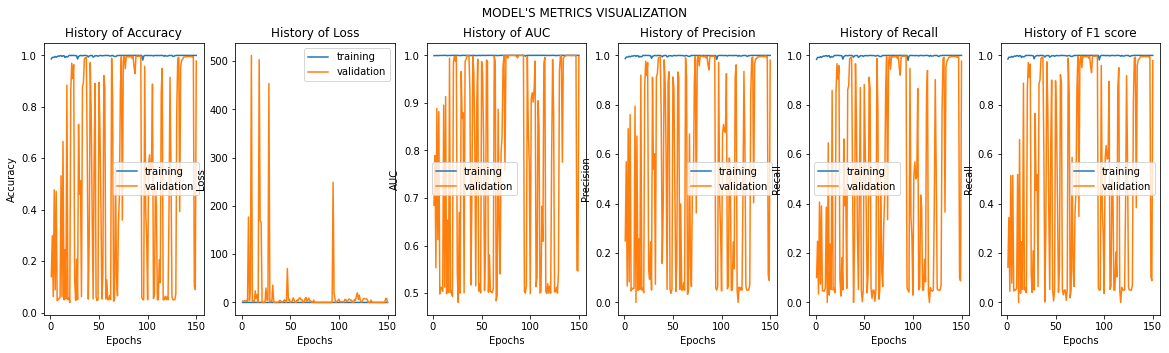

In [23]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall,f1_score,val_f1_score):
    
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])

    ax6.plot(range(1, len(f1_score) + 1), f1_score)
    ax6.plot(range(1, len(val_f1_score) + 1), val_f1_score)
    ax6.set_title('History of F1 score')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('Recall')
    ax6.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['recall'],history.history['val_recall'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [24]:
#model.save('efficientnetB01.hdf5')
model = K.models.load_model("/content/efficientnetB01.hdf5", custom_objects={"f1_score": f1_score})
name_last_layer = str(model.layers[-1])
name_seclast_layer = str(model.layers[-2])

model2 = K.Sequential()
for layer in model.layers:
    if str(layer) != name_last_layer:
       if str(layer) != name_seclast_layer:
        model2.add(layer)
        
model2.summary()   

model2.save('efficientnetB01_mod.hdf5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
Total params: 4,049,571
Trainable params: 4,007,548
Non-trainable params: 42,023
_________________________________________________________________


# Testing

In [40]:
model = K.models.load_model("/content/efficientnetB01.hdf5", custom_objects={"f1_score": f1_score})
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
loss,accuracy,precision,recall,auc,f1_score = model.evaluate(test_dataset)
print("Testing Loss:")
print(loss)
print("Testing Accuracy:")
print(accuracy)
print("Testing Precision:")
print(precision)
print("Testing Recall:")
print(recall)
print("Testing F1-Score:")
print(f1_score)
print("Testing AUC:")
print(auc)

32/32 [==============================] - 4s 131ms/step - loss: 0.1197 - accuracy: 0.9746 - precision: 0.9770 - recall: 0.9741 - auc: 0.9955 - f1_score: 0.9743
Testing Loss:
0.11965586990118027
Testing Accuracy:
0.974588930606842
Testing Precision:
0.977011501789093
Testing Recall:
0.9740906953811646
Testing F1-Score:
0.9742833971977234
Testing AUC:
0.9955399632453918


<ipython-input-38-918290b6fc63>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)


Confusion Matrix


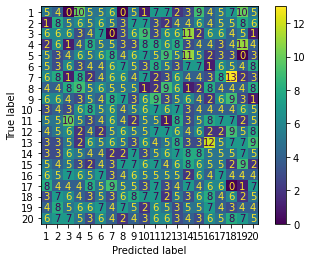

Classification Report
              precision    recall  f1-score   support

           1       0.06      0.05      0.05       100
           2       0.08      0.08      0.08       100
           3       0.06      0.06      0.06       100
           4       0.04      0.04      0.04       100
           5       0.05      0.05      0.05       100
           6       0.04      0.04      0.04       100
           7       0.06      0.06      0.06       100
           8       0.06      0.05      0.05       100
           9       0.03      0.03      0.03       100
          10       0.06      0.06      0.06       100
          11       0.04      0.05      0.05       100
          12       0.07      0.07      0.07       100
          13       0.07      0.07      0.07       107
          14       0.08      0.08      0.08       100
          15       0.06      0.06      0.06       100
          16       0.04      0.04      0.04       100
          17       0.06      0.06      0.06       100
     

In [38]:
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))